In [172]:
import re
import pickle

import networkx as nx

from IPython.display import Image, display
from collections import defaultdict, Counter
from textblob import TextBlob
from itertools import combinations
from tqdm import tqdm

from litecoder.db import City

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('seaborn-muted')

In [3]:
def tokenize(text):
    return [str(t) for t in TextBlob(text).tokens]

In [25]:
def keyify(text):
    text = text.lower()
    text = re.sub('[^a-z0-9]', '', text)
    return text

In [29]:
class Token:
    
    def __init__(self, token, ignore_case=True, scrub_re='\.'):
        
        self.ignore_case = ignore_case
        self.scrub_re = scrub_re
        
        self.token = token
        self.token_clean = self._clean(token)
        
    def _clean(self, token):
        
        if self.ignore_case:
            token = token.lower()
            
        if self.scrub_re:
            token = re.sub(self.scrub_re, '', token)
            
        return token
    
    def __call__(self, input_token):
        return self._clean(input_token) == self.token_clean
    
    def __repr__(self):
        return '%s<%s>' % (self.__class__.__name__, self.token_clean)
    
    def __str__(self):
        return '<%s>' % self.token_clean
    
    def __hash__(self):
        # TODO: Class identifier?
        return hash((self.token_clean, self.ignore_case, self.scrub_re))
    
    def __eq__(self, other):
        return hash(self) == hash(other)
    
    def key(self):
        return keyify(self.token)

In [160]:
class CityFSA(nx.MultiDiGraph):
    
    # Global id counter.
    _next_id = 1
    
    @classmethod
    def from_db_row(cls, row):
        """Build from city db row.
        """
        g = cls(row.wof_id)
        
        name_tokens = tokenize(row.name)
        state_tokens = tokenize(row.name_a1)

        # City name
        parent = g.add_tokens([Token(t) for t in name_tokens])

        # Optional comma
        comma = g.add_token(Token(','), parent, optional=True)

        # State name
        leaf = g.add_tokens([Token(t) for t in state_tokens], comma)
        g.set_final(leaf)

        # Or, state abbr
        leaf = g.add_token(Token(row.us_state_abbr), comma)
        g.set_final(leaf)
        
        return g
    
    def __init__(self, id):
        """Set table + id, root node.
        """
        super().__init__()
        self.id = id
        self.start_node = 0
        
    def next_node(self):
        """Get next integer node id, counting up.
        """
        node = self._next_id
        
        self.add_node(node)
        self.__class__._next_id += 1
        
        return node
    
    def set_final(self, state):
        self.node[state]['final'] = True
        
    def add_token(self, accept_fn, parent=None, optional=False):
        """Register a token transition.
        """
        s1 = parent if parent else self.start_node
        s2 = self.next_node()
        
        self.add_edge(s1, s2, accept_fn=accept_fn, label=str(accept_fn))
        
        last_node = s2
        
        # Add skip transition if optional.
        if optional:
            s3 = self.next_node()
            self.add_edge(s2, s3, label='ε')
            self.add_edge(s1, s3, label='ε')
            last_node = s3
        
        return last_node
    
    def add_tokens(self, tokens, parent=None):
        """Add sequence of tokens
        """
        for token in tokens:
            parent = self.add_token(token, parent)
            
        return parent
    
    def start_keys_iter(self):
        """Generate start keys.
        """
        for _, _, data in self.out_edges(self.start_node, data=True):
            accept_fn = data.get('accept_fn')
            if accept_fn:
                yield accept_fn.key()

In [153]:
def plot(g):
    dot = nx.drawing.nx_pydot.to_pydot(g)
    dot.set_rankdir('LR')
    display(Image(dot.create_png()))

In [154]:
g = CityFSA(10)
san = g.add_token(Token('San'))
francisco = g.add_token(Token('Francisco'), san)
comma = g.add_token(Token(','), francisco, optional=True)
ca = g.add_token(Token('CA'), comma)
california = g.add_token(Token('California'), comma)

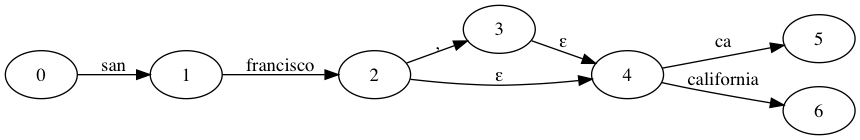

In [155]:
plot(g)

In [161]:
g = CityFSA.from_db_row(City.query.first())

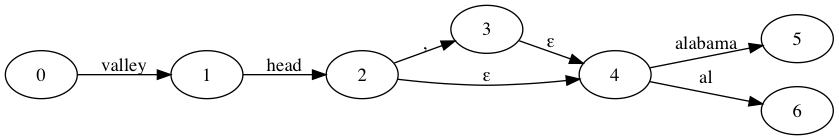

In [162]:
plot(g)

In [171]:
idx = defaultdict(list)
for row in tqdm(City.query.filter(City.country_iso=='US')):
    
    try:
        fsa = CityFSA.from_db_row(row)
    except Exception as e:
        print(row.wof_id, row.name)
    
    for key in fsa.start_keys_iter():
        idx[key].append(fsa)

29808it [00:11, 2517.70it/s]

101734373 Pagai
101734375 Matu'u
101734377 Masefau
101734379 Masausi
101734381 Onenoa
101734383 Faga'alu
101734385 Avaio
101734387 Lauli'i
101734391 Fatumafuti
101734393 Fagatogo
101734395 Auto
101734397 Anua
101734399 Amouli
101734401 Nu'uuli
101734403 Fagasa
101734405 Faganeanea
101734409 Faga'itua
101734411 Leloaloa
101734413 Aunu'u
101734415 Aumi
101734417 Auasi
101734419 Aua
101734421 Atu'u
101734423 Aoa
101734427 Amaua
101734429 Alofau
101734431 Alega
101734433 Alao
101734435 Afono
101734437 Tafuna
101734439 Malaeimi
101734441 Satala
101734445 Utusia
101734447 Aasu
101734449 Vatia
101734451 Utumea East
101734453 Utulei
101734455 Tula
101734457 Sa'ilele
101734463 Si'ufaga
101734465 Olosega
101734467 Ofu
101734469 Maia
101734471 Sili
101734473 Leusoali'i
101734475 Faleasao
101734477 Luma
101734483 Taputimu
101734485 Se'etaga
101734487 Poloa
101734489 Pava'ia'i
101734491 Nua
101734493 Mesepa
101734495 Mapusagafou
101734499 Maloata
101734501 Malaeloa/Ituau
101734503 Malaeloa/Aitulagi

30481it [00:12, 2531.43it/s]

Phillips
1125774497 China
1125776243 Waterville Valley
1125776251 North Haverhill
1125776263 Coeymans
1125776607 Fairchild Air Force Base
1125776627 Whiteman Air Force Base
1125776631 Beale Air Force Base
1125776649 Holloman Air Force Base
1125776659 Lackland Air Force Base
1125776823 Fairfield Heights
1125777607 Town of Hideout
1125777765 Penobscot
1125777893 Wheeler Air Force Base
1125778055 Attu Station
1125778159 Makakilo City
1125778691 Florenceville
1125779339 West Jacksonville
1125779849 Londontowne
1125780343 Roma-Los Saenz
1125780703 Bushland


31503it [00:12, 2551.16it/s]

1125780837 Idyllwild
1125780991 Big Sur
1125781399 Lake Pleasant
1125781523 Keokea
1125786513 Puerto de Anapra


32174it [00:12, 2562.64it/s]

1125788117 Whitesboro-Burleigh
1125788177 East Hill-Meridian
1125788745 De Kalb Junction
1125788871 Queens
1125789015 Huntingtown Town Center
1125789335 Arrowsic
1125790215 Fort McKinley
1125792419 York Haven Anchorage
1125793019 Ledyard Center
1125793231 Buffalo (historical)


33237it [00:12, 2585.48it/s]

1125797273 Grand Lake Stream
1125799447 Del Bonita
1125802705 Pleasant Lake
1125803293

33585it [00:12, 2591.47it/s]

 Trial
1125805373 Bailey Lake
1125805493 Long Settlement
1125805579 Laurel Mountain Park


34544it [00:13, 2512.15it/s]

1125806255 Lake Shangrila
1125806327 Superior Village
1125806419 East La Mirada
1125807033 Punalu‘u


35832it [00:14, 2532.06it/s]

1125820391 Howie In The Hills
1125820657 Lakeside Green
1125820685 Jupiter Inlet Beach Colony
1125820741 New Limerick
1125822963 Sweeney Ranch
1125822975 The Buttes
1125824377 Sunset Acres Colonia
1125824385 Sunset Colonia
1125825373 Port Washington


36799it [00:14, 2546.12it/s]

1125827201 Clair Parish
1125829167 Eagerville
1125829257 Willow Creek
1125829271 Gilgo-Oak Beach-Captree
1125830351 Sleeman


37758it [00:14, 2559.18it/s]

1125833933 Enchanted Hills
1125834051 Wapanitia
1125835351 Oak Cliff Place
1125835655 Weld


38399it [00:14, 2567.76it/s]

1125837939 Boylston
1125838581 Hodgdon
1125839603 Ewa Villages


39697it [00:15, 2585.22it/s]

1125849023 East Pensacola Heights
1125849037 Mission Bay
1125851485 Cobalt Village
1125851699 North Peoria
1125851745 Sunderland
1125851783 Sandy River
1125851965 Allenstown Elementary School
1125851971 Derry Village
1125851983 Borough of Far Hills
1125852135 Central Valley (historical)
1125852145 Hanks
1125852177 Wiseman
1125852765 Building 706
1125852987 Vienna Center
1125853471 Scott Air Force Base
1125853971 Weallup Lake
1125853987 Meadow Lark Lake


40338it [00:15, 2590.99it/s]

1125854657 Hickory Withe
1125859399 Eau Claire
1125859627 Osborne
1125860537 Colonia Iglesia Antigua
1125860545 Four Points Colonia
1125860563 New Hope (historical)
1125860569 Ranchos Penitas West
1125861769 Mountain Home Air Force Base
1125863877 Sarnia Indian Reserve 45
1125863947 Chilmark
1125866897 Boscawen


41295it [00:15, 2602.27it/s]

1125870397 East Longmeadow
1125871145 Water Mill
1125872013 Carrollwood Village
1125872033 Hamptons at Boca Raton
1125872057 Terra Mar
1125872753 West Barnstable
1125873133 North Providence
1125873259 Thornton
1125873305 Helena
1125873905 Seven Trees
1125873979 Wai‘ōhinu
1125874207 Saint Dennis
1125875301 Pierron
1125875467 Dunkirk Town Center
1125875571 Irish Settlement
1125875605 Smokey Point
1125875723 Ka‘a‘awa
1125876273 Saint Andrews
1125876413 Glen Rose
1125876869 Fairgarden
1125876877 Alton North (historical)
1125876885 Alto Bonito Colonia


41942it [00:16, 2609.96it/s]

1125876893 Amargosa Colonia
1125876899 Amaya Colonia
1125876907 B and E Colonia
1125876917 Bailey Prairie
1125876931 Buena Vista Colonia
1125876943 Cameron Park Colonia
1125876961 Chula Vista Colonia
1125876983 Coyote Acres Colonia
1125876993 Del Sol Colonia
1125877009 Edgewater-Paisano
1125877017 El Cenizo Colonia
1125877029 El Refugio Colonia
1125877039 Hilltop Colonia
1125877053 La Paloma Addition Colonia
1125877063 Lago Vista Colonia
1125877079 Las Colonias
1125877093 Loma Linda Colonia
1125877103 Loma Linda East Colonia
1125877109 Loma Vista Colonia
1125877125 Los Altos Colonia
1125877139 Murillo
1125877165 Orason Acres Colonia
1125877171 Paisano Park Colonia
1125877187 Pueblo Nuevo Colonia
1125877197 Taft Southwest (historical)
1125877207 San Carlos Number 1 Colonia
1125877219 San Juan Colonia
1125877229 Santa Rosa Colonia
1125877247 Willamar
1125877251 Zapata Ranch Colonia
1125877371 Saint John
1125877605 Alstead
1125877625 Litchfield
1125879031 Saint Xavier
1125879247 Harpswell

42918it [00:16, 2621.33it/s]


1125885417 Grand Forks Air Force Base
1125885531 Beaverdam Lake–Salisbury Mills
1125885543 Leisure Village West-Pine Lake Park
1125885721 Evergreen Colonia
1125885733 Los Ebanos Colonia
1125885743 Morgan Farm
1125885767 Echo Lake
1125886055 Pine Level
1125886151 Wyman
1125886731 Pumphrey
1125887309 Las Quintas Fronterizas Colonia
1125887313 Socorro Mission Number 1 Colonia
1125887329 Boulder Town
1125887341 Mount Nebo
1125887439 Grouse
1125887453 Peck
1125887457 State Line Village
1125887567 Jonesport
1125887617 Medway
1125887623 Monhegan
1125888199 Guildhall
1125889075 Deschutes River Woods
1125889089 Cayuse
1125889257 Brooklin
1125889269 Kenduskeag
1125889295 Barnesboro
1125889301 Oquirrh
1125889323 West Longview
1125889329 West Wenatchee
1125889341 Satus
1125889351 Foxpark
1125889919 Laughlin Air Force Base
1125889927 Nellis Air Force Base
1125889935 Vandenberg Air Force Base
1125890103 Nikolski
1125890423 Gilford
1125890427 River Vale
1125890619 McCook
1125892939 Elko
1125893285 O

43575it [00:16, 2629.30it/s]

1125894255 Edwards Air Force Base
1125895663 Shutesbury
1125895981 Meyers Chuck
1125895989 Yakutat
1125896491 Delmar
1125897531 Cummings Cove
1125897743 Fitzwilliam
1125898187 Metigoshe
1125898841 Tierra Bonita Colonia
1125900077 Fort Hill Census Designated Place
1125900161 New Portland
1125900169 Robbinston
1125900175 Roque Bluffs
1125900191 Chesterville
1125900367 Black Rock City
1125900385 Offutt Air Force Base
1125900399 Tyndall Air Force Base
1125900561 Green Haven
1125901459 La Crosse
1125903629 Kapa‘a


44222it [00:16, 2634.32it/s]

1125903693 Kaanapali Landing
1125906027 Chopaka
1125906591 Manuel Ojinaga
1125912257 Sherman
1125912499 Kaiser
1125913355 Medusa
1125915557 Windsor Heights
1125915565 Grand Canyon
1125916691 Saint Paul


45195it [00:17, 2644.64it/s]

1125924645 Robins Air Force Base
1125924655 Bangor Trident Base
1125924679 Malmstrom Air Force Base
1125924693 March Air Force Base
1125924707 McChord Air Force Base
1125929193 Castle Pines North


46493it [00:17, 2658.24it/s]

1125947645 Saint Pauls
1125951169 Hebron


48154it [00:18, 2589.36it/s]

1125951785 Holliston
1125962067 Rochelle Park
1125962389 Dewdney
1125962403 Kettle Falls
1125962885 Sasabe
1125969347

49137it [00:18, 2600.19it/s]

 Chesterfield Court House
1125970131 Edgartown
1125970989 Belmont
1125973263 Quail Valley
1125977413 Vicente Guerrero (algodones)
1125977439 Ejido Jacume


49807it [00:19, 2607.58it/s]

1125980283 Tecate


50851it [00:19, 2619.77it/s]

1125988815 Errol
1125989355 Shapleigh
1125995631 Central Waterford
1125995639 Grissom Air Force Base
1125995647

51513it [00:19, 2625.97it/s]

 K. I. Sawyer Air Force Base
1125995703 Warren Air Force Base
1125996389 Rangeley
1125996409 Premier


52165it [00:19, 2631.81it/s]

1126006035 Allagash
1126007899 Conning Towers Nautilus Park
1126007911 Old Saybrook Center
1126013545 Guilford Siding
1126016027 Hove Mobile Park
1126016593 Rio en Medio
1126017831 Hanapēpē Heights
1126020971

52841it [00:20, 2638.71it/s]

 Tenney
1126021667 Shiloh
1126021785 Airport Road
1126028365 Fort George G Mead Junction
1126028507 Bluetown Colonia
1126028829 Koller
1126028859 Wakenda


54184it [00:20, 2651.76it/s]

1126039173 Barstow Heights
1126040177 Columbus Air Force Base


54513it [00:20, 2654.86it/s]

1126111901 Esri
1126111975 139 Olive Street
1126111979 Park Encinitas Trailer Park


54727it [00:20, 2624.52it/s]


In [173]:
pickle.dump(idx, open('test.p', 'wb'))

In [174]:
max([len(v) for v in idx.values()])

515

In [175]:
c = City.query.get(1125777765)

In [177]:
c.name_a1